In [94]:
# importa as bibliotecas necessárias para utilizar todo o notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [95]:
# Importa DataFrame de treinamento 
df = pd.read_csv('train.csv')
# Importa DataFrame de teste 
tt = pd.read_csv('test.csv')

# Deixa as repostas do pandas com cinco casas decimais, evitando notações científicas
pd.options.display.float_format = '{:.5f}'.format

# Pré-processamento

## Verificação de valores nulos 

In [96]:
df.isnull().sum()

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

&emsp;A partir do método "isnull", são identificados os valores nulos do DataFrame, isto é, os valores "vazios". Com o uso do método "sum", seria calculada a quantidade de aparições em cada coluna. Entretanto, como é possível perceber acima, não há esse tipo de dado no DataFrame. 

## Verificação de linhas duplicadas 

&emsp;Abaixo, é varificada a existência de linhas duplicadas, comparando todas as colunas:

In [97]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [track_unique_id, track_id, artists, album_name, track_name, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre, popularity_target]
Index: []


&emsp;Como o output foi "Empty DataFrame", mostra que não foram encontradas linhas duplicadas.

&emsp;A seguir, é feito o mesmo processo sem as colunas "track_unique_id" e "track_id", ou seja, as colunas que dão a cada registro um código identificador.

In [98]:
df_sem_id = df.drop(columns=['track_unique_id', 'track_id'])

duplicadas = df_sem_id[df_sem_id.duplicated(keep='first')]
duplicadas_index = duplicadas.index

print(duplicadas['artists'].count())
print(f'Shape df antes: {df.shape}')

df = df.drop(index=duplicadas_index)
print(f'Shape df depois: {df.shape}')

368
Shape df antes: (79800, 21)
Shape df depois: (79432, 21)


&emsp;Após essa modificação no DataFrame, foram identificadas 368 linhas duplicadas, as quais foram removidas.

## Análise descritiva

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79432 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79432 non-null  int64  
 1   track_id           79432 non-null  object 
 2   artists            79432 non-null  object 
 3   album_name         79432 non-null  object 
 4   track_name         79432 non-null  object 
 5   duration_ms        79432 non-null  int64  
 6   explicit           79432 non-null  bool   
 7   danceability       79432 non-null  float64
 8   energy             79432 non-null  float64
 9   key                79432 non-null  int64  
 10  loudness           79432 non-null  float64
 11  mode               79432 non-null  int64  
 12  speechiness        79432 non-null  float64
 13  acousticness       79432 non-null  float64
 14  instrumentalness   79432 non-null  float64
 15  liveness           79432 non-null  float64
 16  valence            79432 no

&emsp;Como colunas quantitativas, foram identificadas:

* "duration_ms"
* "loudness"
* "tempo"

&emsp;Assim, foi utilizado o método "describe" nelas, a fim de extrair algun dados matemáticos essenciais para a análise exploratória que será feita.

In [100]:
numeric_cols = df[['duration_ms', 'loudness', 'tempo']]
numeric_cols.describe()

,duration_ms,loudness,tempo
count,79432.00000,79432.00000,79432.00000
mean,227958.58983,-8.25191,122.09319
std,103871.60083,5.02405,29.93014
min,13386.00000,-49.30700,0.00000
25%,174545.00000,-9.99500,99.13325
50%,212893.00000,-7.00600,122.01200
75%,261506.00000,-4.99700,140.05400
max,5237295.00000,4.53200,222.60500


## Transformação das colunas qualitativas

&emsp;A seguir, a coluna com valores booleanos identificados como "True" ou "False", terá eles transformados em 1 e 0, respectivamente. Já aquelas qualitativas com seus valores em formato de string, cada elemento será trocado por um número único para ele. Tudo isso será feito criando novas colunas.

### Coluna "explicit" 

&emsp;Antes:

In [101]:
df['explicit'].value_counts()

explicit
False    72629
True      6803
Name: count, dtype: int64

&emsp;Depois:

In [102]:
df['explicit_num'] = df['explicit'].astype(int)
df['explicit_num'].value_counts()

explicit_num
0    72629
1     6803
Name: count, dtype: int64

### Coluna "artists"

&emsp;Antes:

In [103]:
print(df['artists'].head())

0     Love and Rockets
1     Filippa Giordano
2        Susumu Yokota
3    Franz Liszt;YUNDI
4              Scooter
Name: artists, dtype: object


&emsp;Depois:

In [104]:
df['artists_encoded'] = df['artists'].astype('category').cat.codes
print(df['artists_encoded'].head())

0    13481
1     7754
2    21526
3     8029
4    20008
Name: artists_encoded, dtype: int16


### Coluna "album_name"

&emsp;Antes:

In [105]:
print(df['album_name'].head())

0        Love and Rockets
1        Filippa Giordano
2                  Symbol
3    Relajación y siestas
4         Scooter Forever
Name: album_name, dtype: object


&emsp;Depois:

In [106]:
df['album_name_encoded'] = df['album_name'].astype('category').cat.codes
print(df['album_name_encoded'].head())

0    18054
1    10815
2    28726
3    24834
4    26251
Name: album_name_encoded, dtype: int32


### Coluna "track_name"

&emsp;Antes:

In [107]:
print(df['track_name'].head())

0                                Motorcycle
1    Addio del passato - From "La traviata"
2                        Purple Rose Minuet
3              Liebeslied (Widmung), S. 566
4                              The Darkside
Name: track_name, dtype: object


&emsp;Depois:

In [108]:
df['track_name_encoded'] = df['track_name'].astype('category').cat.codes
print(df['track_name_encoded'].head())

0    29483
1     1549
2    35849
3    25598
4    44199
Name: track_name_encoded, dtype: int32


### Coluna "track_genre"

&emsp;Antes:

In [109]:
print(df['track_genre'].head())

0         goth
1        opera
2          idm
3    classical
4       techno
Name: track_genre, dtype: object


&emsp;Depois:

In [110]:
df['track_genre_encoded'] = df['track_genre'].astype('category').cat.codes
print(df['track_genre_encoded'].head())

0     41
1     76
2     54
3     16
4    109
Name: track_genre_encoded, dtype: int8


## Análise de Outliers

&emsp;Essa função será utilizada como base para gerar a análise dos cluster de cada feature:

In [111]:
def outliers_count(col):
    q1 = df[col].quantile(0.25)
    # q2 = df[col].quantile(0.5)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    limite_superior = q3 + (1.5 * iqr)
    bool_superior = df[col] > limite_superior
    count_superior = bool_superior.loc[bool_superior == True].count()

    limite_inferior = q1 - (1.5 * iqr)
    bool_inferior = df[col] < limite_inferior
    count_inferior = bool_inferior.loc[bool_inferior == True].count()

    print(f'Limite Superior: {limite_superior:.3f}')
    print(f'Quantidade de Outliers Superiores: {count_superior}')
    print('\n')
    print(f'Limite Inferior: {limite_inferior:.3f}')
    print(f'Quantidade de Outliers Inferiores: {count_inferior}')

&emsp;As seções abaixo serão separadas pelas features quantitativas. Dentro de cada uma, haverá:

* **Boxplot**: gráfico utilizado para analisar os outliers;
* **Seção "Análise de Outliers"**: iniciará com uma breve descrição sobre as informações trazidas pelo gráfico;
    * **Seção "Inferior"**: onde serão tratados os outliers de valores baixos;
    * **Seção "Superior"**: onde serão tratados os outliers de valores altos;

### Duração da música

&emsp;Criação das colunas: "duration_seg", que contém a duração das músicas em segundos; e "duration_min", que apresenta a duração das músicas em minutos.

In [112]:
df['duration_seg'] = df['duration_ms'] / 1000
df['duration_min'] = df['duration_ms'] / (1000 * 60)

df[['duration_ms', 'duration_seg', 'duration_min']].head(10)

,duration_ms,duration_seg,duration_min
0,211533,211.53300,3.52555
1,196000,196.00000,3.26667
2,216506,216.50600,3.60843
3,218346,218.34600,3.63910
4,173160,173.16000,2.88600
5,242333,242.33300,4.03888
6,254306,254.30600,4.23843
7,130634,130.63400,2.17723
8,79764,79.76400,1.32940
9,354375,354.37500,5.90625


&emsp;Criação do boxplot:

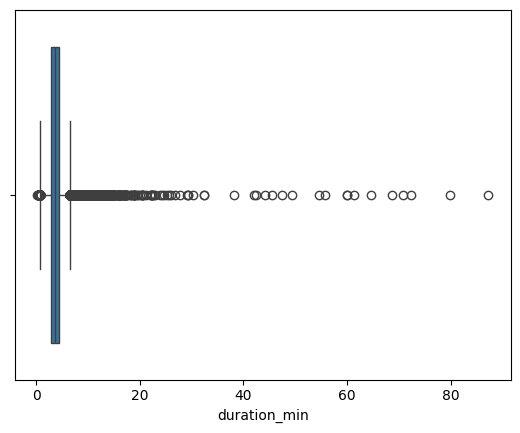

In [113]:
sns.boxplot(x=df['duration_min'])
plt.show()

#### Análise de outliers

In [114]:
outliers_count('duration_min')

Limite Superior: 6.532
Quantidade de Outliers Superiores: 3772


Limite Inferior: 0.735
Quantidade de Outliers Inferiores: 201


##### Inferior 

&emsp;Breve análise sobre qual seria o limite mínimo para a duração da música:

In [115]:
print(df[df['duration_min'] < 0.7]['duration_min'].count())

df[(df['duration_min'] < 0.7) & (df['popularity_target'] == 0.7)]['duration_min'].count()

172


np.int64(0)

&emsp;Remoção dos outliers:

In [116]:
df = df[~(df['duration_min'] < 0.7)]

print(df[df['duration_min'] < 0.7]['duration_min'].count())

0


##### Superior

&emsp;Breve análise sobre qual seria o limite mínimo para a duração da música:

In [117]:
print(df[df['duration_min'] > 8]['duration_min'].count())

print(df[(df['duration_min'] > 8) & (df['popularity_target'] == 1)]['duration_min'].count())

1333
507


&emsp;Remoção dos outliers:

In [118]:
df = df[~(df['duration_min'] > 8)]

print(df[df['duration_min'] > 8]['duration_min'].count())

0


### Nível geral do volume em decibéis (dB)

&emsp;Criação do boxplot:

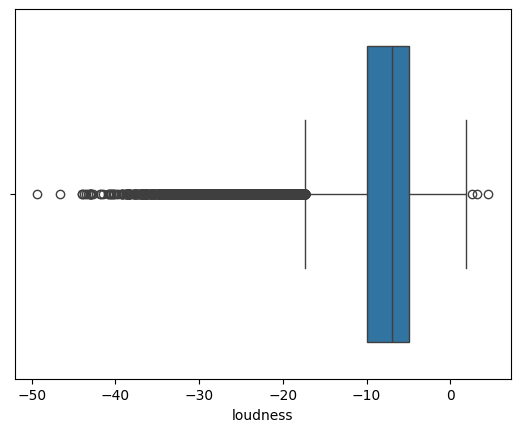

In [119]:
sns.boxplot(x=df['loudness'])
plt.show()

#### Análise de Outliers 

In [120]:
outliers_count('loudness')

Limite Superior: 2.455
Quantidade de Outliers Superiores: 3


Limite Inferior: -17.343
Quantidade de Outliers Inferiores: 4173


##### Inferior 

&emsp;Breve análise sobre qual seria o limite mínimo para a duração da música:

In [121]:
print(df[df['loudness'] < -40]['loudness'].count())

25


&emsp;Remoção dos outliers:

In [122]:
df = df[~(df['loudness'] < -40)]

print(df[df['loudness'] < -40]['loudness'].count())

0


##### Superior

&emsp;Remoção dos outliers:

In [123]:
df = df[~(df['loudness'] > 2.509)]

print(df[df['loudness'] > 2.509]['loudness'].count())

0


### Tempo estimado da faixa em batidas por minuto (BPM)

&emsp;Criação do boxplot:

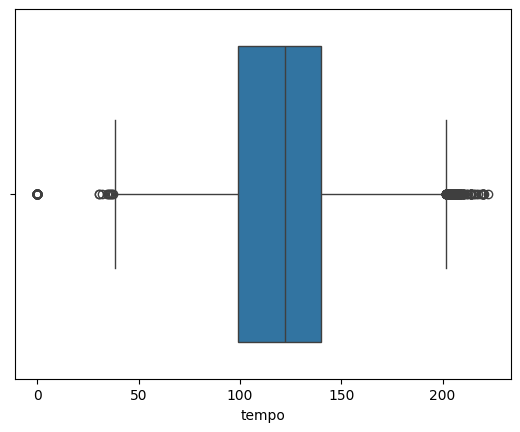

In [124]:
sns.boxplot(x=df['tempo'])
plt.show()

#### Análise de Outliers 

In [125]:
outliers_count('tempo')

Limite Superior: 201.598
Quantidade de Outliers Superiores: 309


Limite Inferior: 37.548
Quantidade de Outliers Inferiores: 96


##### Inferior 

&emsp;Breve análise sobre qual seria o limite mínimo para a duração da música:

In [126]:
print(df[df['tempo'] == 0]['tempo'].count())

86


&emsp;Remoção dos outliers:

In [127]:
df = df[~(df['tempo'] == 0)]

print(df[df['tempo'] == 0]['tempo'].count())

0


##### Superior 

&emsp;Breve análise sobre qual seria o limite mínimo para a duração da música:

In [128]:
print(df[df['tempo'] > 200]['tempo'].count())

408


&emsp;Remoção dos outliers:

In [129]:
df = df[~(df['tempo'] > 200)]

print(df[df['tempo'] > 200]['tempo'].count())

0


# Análise Exploratória 

## Hipóteses

### Hipótese 1

&emsp;Considerando um contexto geral onde todos escutam músicas não explícitas, porém algumas pessoas podem apresentar resistência a músicas explícitas, a primeira hipótese seria:

* **Ao comparar o número de músicas explícitas no geral, o número seria mais alto do que entre as populares.**

### Hipótese 2

&emsp;Ao pensar no gênero das músicas mais famosas, a segunda hipótese seria:

* **O gênero Pop está entre os três mais famosos.**

### Hipótese 3

&emsp;Considerado a área de concentração dos ouvintes, a terceira hipótese seria:

* **Gêneros típicos de certas regiões tendem a ser menos populares.**

## Gráficos

### Gráfico 1

&emsp;A imagem abaixo compara a quantidade de músicas populares explícitas e não explícitas no âmbito geral e entre as populares:

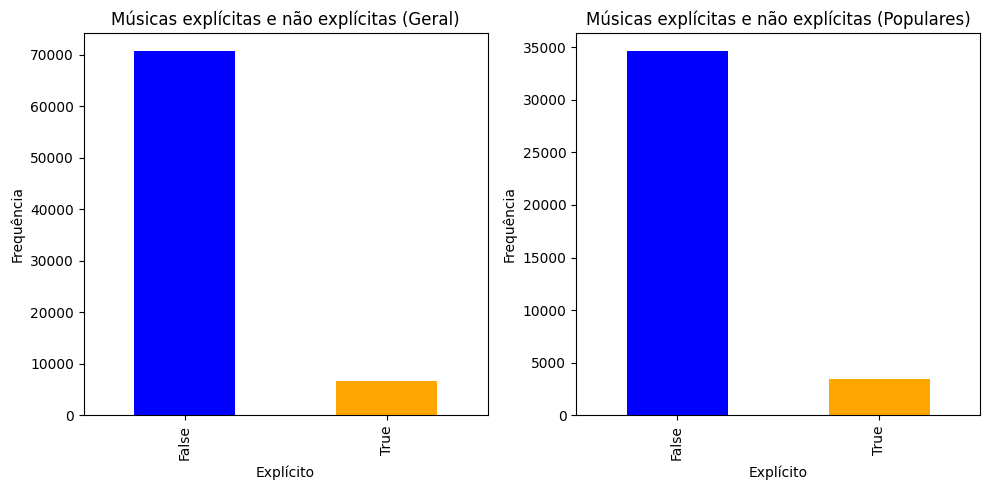

In [130]:
popularity = df[df['popularity_target'] == 1]

explicit_geral = df['explicit'].value_counts()
explicit_popular = popularity['explicit'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico Geral
explicit_geral.plot(kind='bar', ax=ax1, color=['blue', 'orange'])
ax1.set_title('Músicas explícitas e não explícitas (Geral)')
ax1.set_xlabel('Explícito')
ax1.set_ylabel('Frequência')

# Gráfico Populares
explicit_popular.plot(kind='bar', ax=ax2, color=['blue', 'orange'])
ax2.set_title('Músicas explícitas e não explícitas (Populares)')
ax2.set_xlabel('Explícito')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.show()


&emsp;Ao analisá-la, é possível desmistificar a primeira hipótese, já que ela contava com uma discrepância ao comparar os dois gráficos apresentados.

### Gráfico 2

&emsp;O gráfico abaixo mostra os dez gêneros mais frequentes entre as músicas classificadas como populares:

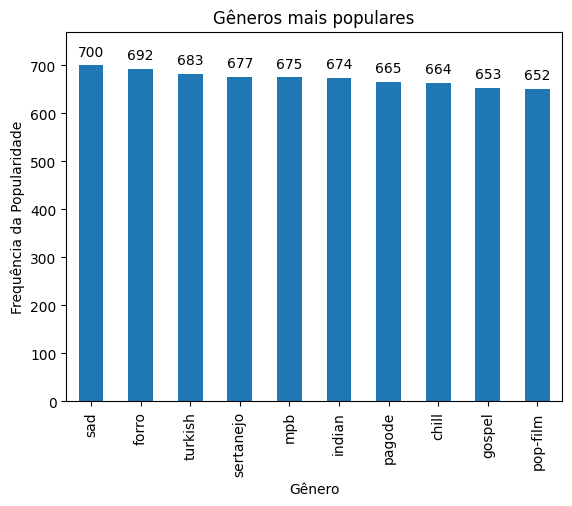

In [131]:
generos_dez_mais = popularity['track_genre'].value_counts().nlargest(10).sort_values(ascending=False)

ax = generos_dez_mais.plot(kind='bar')

# Título e rótulos
ax.set_title('Gêneros mais populares')
ax.set_xlabel('Gênero')
ax.set_ylabel('Frequência da Popularidade')

# Ajustar o limite do eixo Y para garantir que os números não sejam cortados
ax.set_ylim(0, generos_dez_mais.max() * 1.1)  # Aumenta o limite superior em 10%

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

&emsp;Considerando o gráfico acima, é possível descartar a hipótese dois, onde foi imposta a ideia do pop ser um dos gêneros mais populares.

### Gráfico 3

&emsp;O gráfico a seguir mostra os dez gêneros mais frequentes entre as músicas não populares:

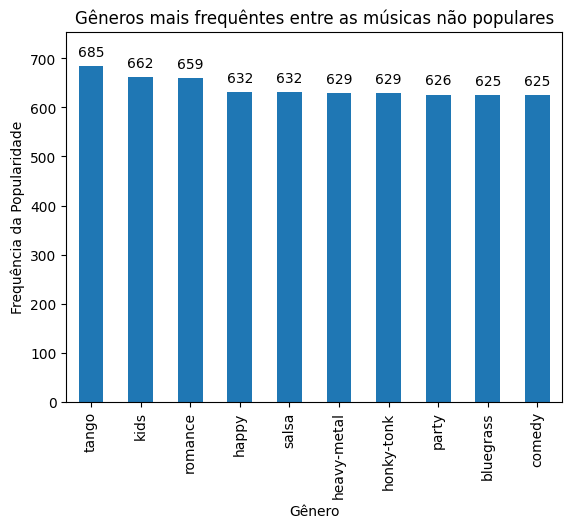

In [132]:
no_popularity = df[df['popularity_target'] == 0]

generos_dez_mais = no_popularity['track_genre'].value_counts().nlargest(10).sort_values(ascending=False)

ax = generos_dez_mais.plot(kind='bar')

# Título e rótulos
ax.set_title('Gêneros mais frequêntes entre as músicas não populares')
ax.set_xlabel('Gênero')
ax.set_ylabel('Frequência da Popularidade')

# Ajustar o limite do eixo Y para garantir que os números não sejam cortados
ax.set_ylim(0, generos_dez_mais.max() * 1.1)  # Aumenta o limite superior em 10%

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

&emsp;Considerando seu resultado, a hipótese três foi comprovada, já que gêneros como "tango" estão entre os gêneros mostrados.

### Matriz de Correlação

&emsp;Apartir da matriz de correlação, é possível identificar quais features podem ser mais relevantes para o modelo preditivo.

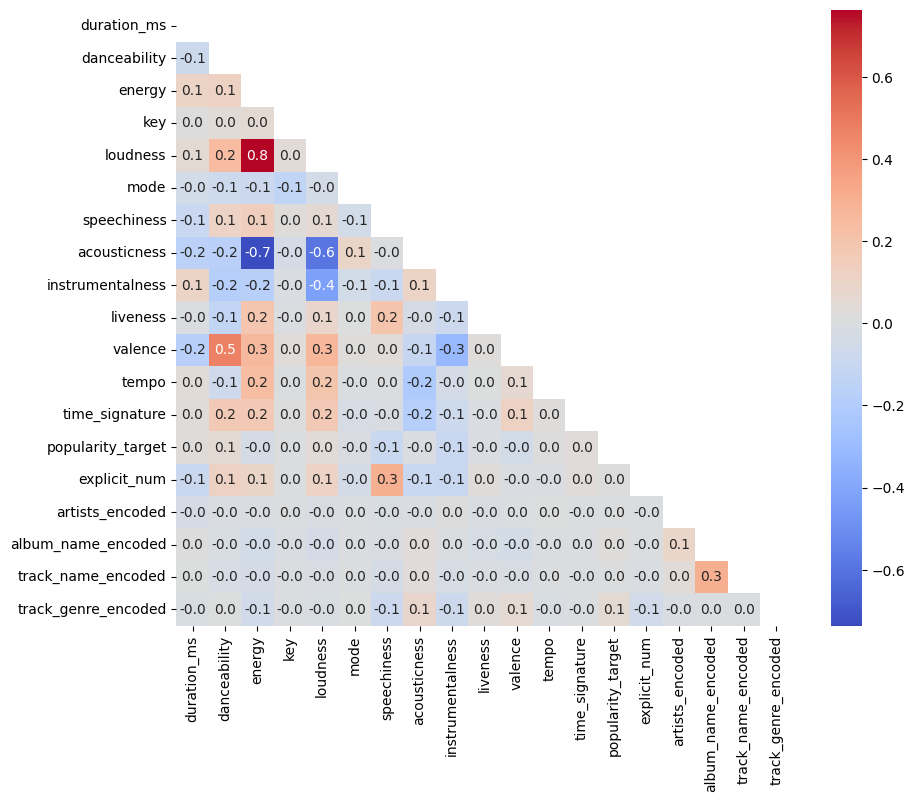

In [133]:
cols_heat = df[['duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature','popularity_target', 'explicit_num', 'artists_encoded',
       'album_name_encoded', 'track_name_encoded', 'track_genre_encoded']]

corr = cols_heat.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, mask=mask, square=True, annot=True, fmt="0.1f", cmap='coolwarm')

plt.show()

&emsp;Interpretação dos dados:

* **0,9 a 1 (positivo ou negativo):** correlação muito forte;
* **0,7 a 09 (positivo ou negativo):** correlação forte;
* **0,5 a 0,7 (positivo ou negativo):** correlação moderada;
* **0,3 a 0,5 (positivo ou negativo):** correlação fraca;
* **0 a 0,3 (positivo ou negativo):** não possui correlação.

&emsp;Matrizes com maiores correlações:

* loudness e energy (0.8)
* acousticness e energy (-0.7)
* acousticness e loudness (-0.6)
* valence e danceability (0.5)
* intrumentalness e loudness (-0.4)

### Matriz de frequência de cada variável

&emsp;Com os gráficos abaixo, é possível perceber quais valores aparecem com maior frequência dentro de algumas features:

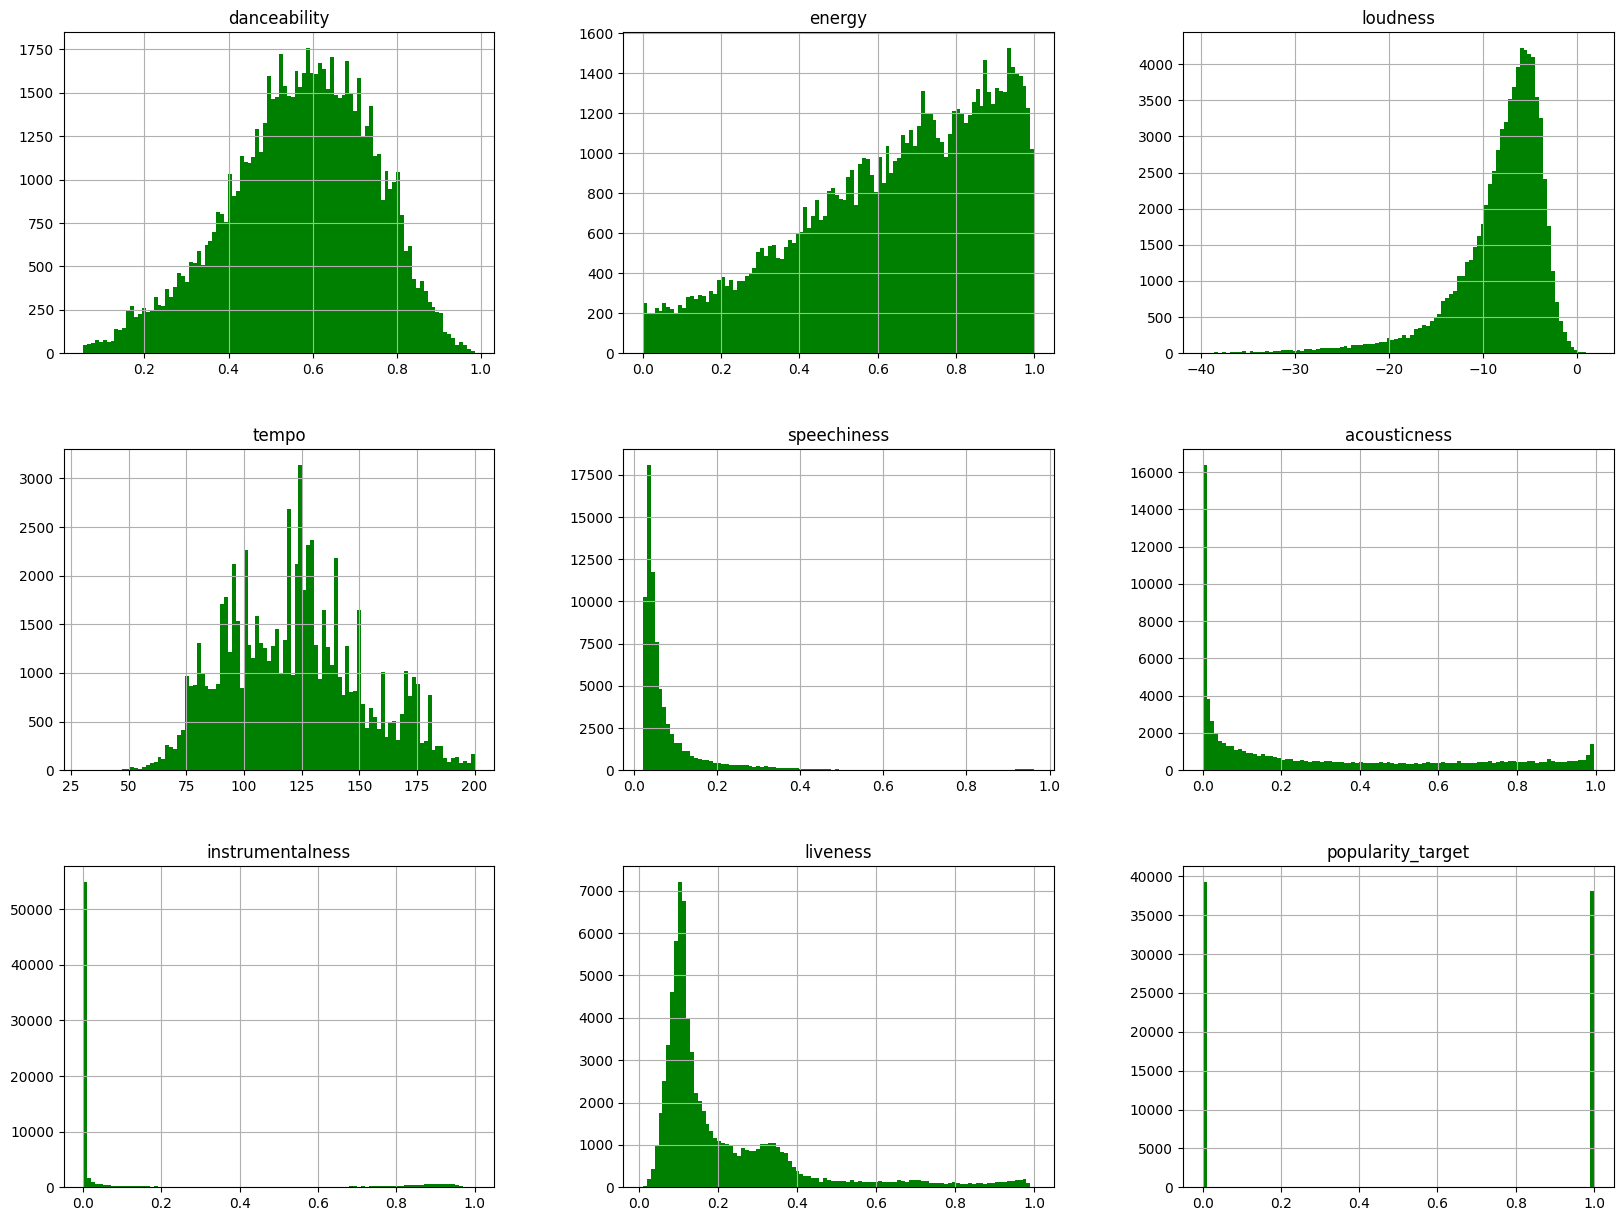

In [134]:
colunas = ['danceability', 'energy', 'loudness', 'tempo', 'explicit', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'popularity_target']

dfm = df.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])

dfm[colunas].hist(bins=100, figsize=(20, 15), color = 'green')
plt.show()

### Análise de importância

&emsp;Aqui, pode ser visto uma análise de importância de algumas features:

In [135]:
dbf = df.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name', 'duration_seg', 'duration_min', 'track_genre'])

X = dbf.drop(columns=['popularity_target'])
y = dbf['popularity_target'] 

decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X, y)

importancia = decision_tree.feature_importances_

feature_importances = pd.DataFrame(importancia, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

                     importance
track_genre_encoded     0.23545
artists_encoded         0.07365
album_name_encoded      0.07106
acousticness            0.06909
duration_ms             0.05857
loudness                0.05750
speechiness             0.05576
danceability            0.05481
track_name_encoded      0.05096
valence                 0.05059
liveness                0.04955
tempo                   0.04743
energy                  0.04681
instrumentalness        0.04558
key                     0.02040
time_signature          0.00470
mode                    0.00435
explicit_num            0.00220
explicit                0.00153


# Modelo

## Igualando o DataFrame de teste

&emsp;Abaixo estão sendo codificadas algumas colunas qualitativas do Dataframe de Teste:

In [136]:
tt['explicit_num'] = tt['explicit'].astype(int)
tt['album_name_encoded'] = tt['album_name'].astype('category').cat.codes
tt['track_name_encoded'] = tt['track_name'].astype('category').cat.codes
tt['track_genre_encoded'] = tt['track_genre'].astype('category').cat.codes
tt['artists_encoded'] = tt['artists'].astype('category').cat.codes

tt.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,explicit_num,album_name_encoded,track_name_encoded,track_genre_encoded,artists_encoded
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.36900,0.59800,7,-6.98400,1,0.03040,0.00511,0.00000,0.17600,0.04660,148.01400,4,world-music,0,11698,15371,113,5751
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.17100,0.99700,7,-3.58600,1,0.11800,0.00521,0.80100,0.42000,0.02940,122.22300,4,grindcore,0,7004,7331,42,6116
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.17300,0.80300,9,-10.07100,0,0.14400,0.61300,0.00191,0.19500,0.08870,75.56400,3,iranian,0,11747,19101,59,14892
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.68300,0.51100,6,-5.59800,1,0.02790,0.40600,0.00020,0.11100,0.59800,109.99100,3,rock,0,1075,14049,90,2086
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.55500,0.94100,9,-3.29400,0,0.04810,0.48400,0.00000,0.26600,0.81300,92.48700,4,j-idol,0,20017,27171,61,9792


## RandomSearch

In [140]:
df_tn = dbf.sample(frac=0.5).copy()

features = ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'album_name_encoded', 'track_genre_encoded', 'artists_encoded']

X = df_tn[features]
y = df_tn['popularity_target']

X_test = tt[features] 

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]  
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='precision', 
    cv=3,  
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X, y)

random_search.best_estimator_
print(f'Best Hyperparameters: {random_search.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


## Random Forest

In [139]:
df_tn = dbf.copy()

features = ['duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'explicit_num', 'album_name_encoded', 'track_name_encoded',
       'track_genre_encoded', 'artists_encoded']

X_train = df_tn[features]
y_train = df_tn['popularity_target']

X_test = tt[features] 

model = RandomForestClassifier(random_state=42, n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, max_features= None, max_depth= None)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

csv = pd.DataFrame({'track_unique_id': tt['track_unique_id'], 'predicted_popularity': y_pred})
csv.to_csv('popularity_pred.csv', index=False)

y_train_pred = model.predict(X_train)

print(f'Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Precision: {precision_score(y_train, y_train_pred)}')
print(f'Recall: {recall_score(y_train, y_train_pred)}')


Accuracy: 0.9998837284413151
Precision: 0.9999212784381643
Recall: 0.9998425692695214
